In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'RK45'
integrator_keywords['atol'] = 1e-12

In [20]:
# Generate measurement data
dt = .01

bounds = [1.6,4]
t_train = np.arange(0, 20, dt)
# x0_train = [0, 0.5]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = True
n_traj = 1000

def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return np.array(y).T

def re(ls, thrsh, num):
    # slice array if it converged
    ct = 0
    for i in range(len(ls)):
        if np.abs(np.sum(ls[i])) < thrsh:
            ct +=1
        elif np.abs(np.sum(ls[i])) >= thrsh:
            ct = 0
        if ct >= num:
            return np.array(ls[:i-ct])
        # if it diverges, slice it
        if ((ls[i][1] > bounds[1]) or (ls[i][0] > bounds[0])):
            return np.array(ls[:i])
    return np.array(ls)

def create_multiple_timeseries(func, n_trajectories, dim):
    x_train_multi = []
    y_train_multi = []
#     x0s = np.random.rand(n_trajectories, dim)
    x0s = np.random.uniform(low=[ -x for x in bounds], high=bounds, size=(n_trajectories,dim))

#     print(x0s)
    for i in range(n_trajectories):
        x_train_temp = solve_ivp(fun = func, t_span=t_train_span, 
                                    y0 = x0s[i], t_eval=t_train, **integrator_keywords).y.T
        # x1_temp = x_train_temp[:,0]
        # x2_temp = x_train_temp[:,1]
        # # print('before: {}'.format(x_train_temp.shape))
        # # print( int(t_train.shape[0] / 10))
        # x1_temp = re(x1_temp, 1e-5, 5)
        # x2_temp = re(x2_temp, 1e-5, 5)
        # print('after: {}'.format(x_train_temp.shape))
        x_train_temp = re(x_train_temp, 1e-4, 5)
        # plt.figure()
        # plt.plot(x_train_temp, label = ['x1', 'x2'])
        # plt.title('x0: {:.2f}, {:.2f}'.format(x0s[i][0], x0s[i][1]))
        # plt.legend()
                        
        x_train_multi.append(x_train_temp)
    # now get finite difference approximations for each time series
    for x_train in x_train_multi:
        forward_diff = np.expand_dims(np.diff(x_train[:,0]) / dt, axis=1)
        forward_diff2 = np.expand_dims(np.diff(x_train[:,1]) / dt, axis=1)
        y_t = np.concatenate([forward_diff, forward_diff2], axis=1)
        y_train_multi.append(y_t)
    # slice first element to match y
    x_train_multi = [i[1:,:] for i in x_train_multi]
    return np.concatenate(x_train_multi), np.concatenate(y_train_multi)
    
x_train_multi, y_train_multi = create_multiple_timeseries(van_der_pol, n_traj, dim)
# t_diff = t_train[:-1:]

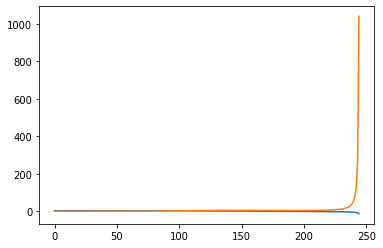

In [21]:
# simple_ex = solve_ivp(fun = van_der_pol, t_span=t_train_span, y0 = [2.26, -0.5], t_eval=t_train, **integrator_keywords).y.T
# plt.plot(simple_ex)

In [22]:
# plt.figure(figsize = (12, 8))
# plt.subplot(121)
# plt.plot(t_diff, y_train_multi[2,:,0], 'k--', \
#          label = 'Finite difference approximation')
# plt.plot(t_diff, x_train_multi[2,:,0], \
#          label = 'x_train')
# plt.plot(t_diff, vf(x_train_multi[2,:,:])[:,0], \
#          label = 'x_dot_exact')
# plt.subplot(122)
# plt.plot(t_diff, y_train_multi[2,:,1], 'k--', \
#          label = 'Finite difference approximation')
# plt.plot(t_diff, x_train_multi[2,:,1], \
#          label = 'x_train')
# plt.plot(t_diff, vf(x_train_multi[2,:,:])[:,1], \
#          label = 'x_dot_exact')
# plt.legend()
# plt.show()

In [23]:
# x_train_multi = np.concatenate(x_train_multi, axis=0)
# y_train_multi = np.concatenate(y_train_multi, axis=0)
X_train, X_test, y_train, y_test = train_test_split(x_train_multi, y_train_multi, test_size=0.3, shuffle=True) #, random_state=100)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)
batch_size = 1024
train_dataset = train_dataset.batch(batch_size)
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# validation_dataset = validation_dataset.shuffle(buffer_size=1024)
validation_dataset = validation_dataset.batch(batch_size)
# validation_dataset.element_spec

In [24]:
l2_coeff = 1e-5
rate = 0.5
reg = regularizers.l2(l2_coeff)
act = 'relu'

model = Sequential([
    Dense(20, activation=act, input_dim=2, kernel_regularizer = reg),
#     Dense(128, activation=act, kernel_regularizer = reg),
    Dense(256, activation=act, kernel_regularizer = reg),
    Dense(256, activation=act, kernel_regularizer = reg),
    Dense(512, activation=act, kernel_regularizer = reg),
    Dense(512, activation=act, kernel_regularizer = reg),
    Dense(512, activation=act, kernel_regularizer = reg),
    Dense(512, activation=act, kernel_regularizer = reg),
    Dense(256, activation=act, kernel_regularizer = reg),
    Dense(2)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 20)                60        
                                                                 
 dense_10 (Dense)            (None, 256)               5376      
                                                                 
 dense_11 (Dense)            (None, 256)               65792     
                                                                 
 dense_12 (Dense)            (None, 512)               131584    
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dense_15 (Dense)            (None, 512)              

In [25]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=15, verbose=1, callbacks=[earlystopping])

Epoch 1/15
506/506 [==============================] - 25s 47ms/step - loss: 0.0492 - mae: 0.0473 - val_loss: 0.0170 - val_mae: 0.0210
Epoch 2/15
506/506 [==============================] - 25s 49ms/step - loss: 0.0136 - mae: 0.0178 - val_loss: 0.0124 - val_mae: 0.0133
Epoch 3/15
506/506 [==============================] - 24s 48ms/step - loss: 0.0109 - mae: 0.0156 - val_loss: 0.0099 - val_mae: 0.0123
Epoch 4/15
506/506 [==============================] - 27s 54ms/step - loss: 0.0085 - mae: 0.0119 - val_loss: 0.0071 - val_mae: 0.0139
Epoch 5/15
506/506 [==============================] - 25s 50ms/step - loss: 0.0094 - mae: 0.0194 - val_loss: 0.0071 - val_mae: 0.0123
Epoch 6/15
506/506 [==============================] - 26s 52ms/step - loss: 0.0064 - mae: 0.0121 - val_loss: 0.0109 - val_mae: 0.0221
Epoch 7/15
506/506 [==============================] - 26s 52ms/step - loss: 0.0058 - mae: 0.0126 - val_loss: 0.0046 - val_mae: 0.0072
Epoch 8/15
506/506 [==============================] - 27s 52ms

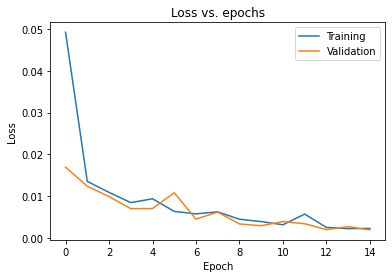

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_mae'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation', 'Validation mae'])
plt.show()

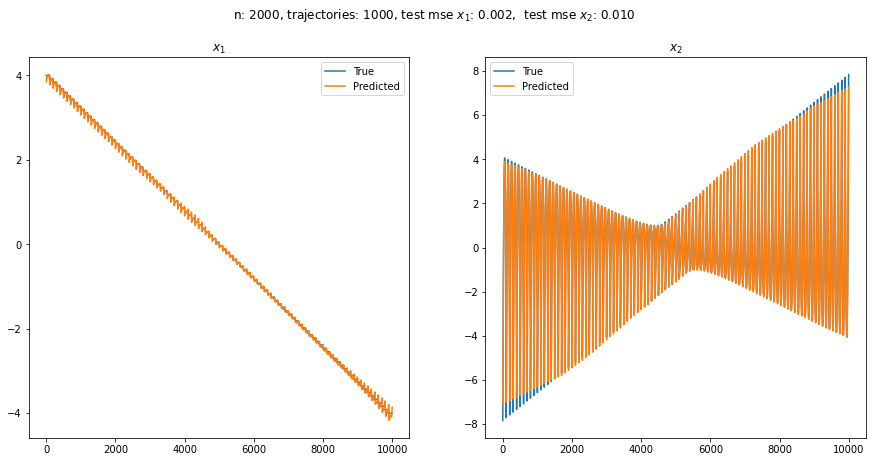

In [30]:
n = [100,100]
bounds = [1.6, 4]
ls = np.stack([n, bounds],axis=1)

def get_grid_of_points(lms):
    ls = [np.linspace(-i,i,int(n)) for n, i in lms]
    mesh_ls = np.meshgrid(*ls)
    all_mesh = [np.reshape(x, [-1]) for x in mesh_ls]
    grid_points = np.stack(all_mesh, axis=1)
    return grid_points
data = get_grid_of_points(ls)

y_pred = model.predict(data)
y_true = vf(data)

plt.figure(figsize=(15,7))
plt.suptitle('n: {}, trajectories: {}, test mse $x_1$: {:.3f},  test mse $x_2$: {:.3f}'.format(
    t_train.shape[0], n_traj, 
    np.mean(np.square(y_true - y_pred), axis=0)[0], np.mean(np.square(y_true - y_pred), axis=0)[1] ))
plt.title('n: {}'.format(n[0]*n[1]))
plt.subplot(121)
plt.plot(y_true[:,0], label = 'True')
plt.plot(y_pred[:,0], label = 'Predicted')
plt.title('$x_1$')
plt.legend()
plt.subplot(122)
plt.plot(y_true[:,1], label = 'True')
plt.plot(y_pred[:,1], label = 'Predicted')
plt.title('$x_2$')
plt.legend()
plt.show()

In [31]:
ep = np.mean(np.square(y_true - y_pred), axis=1)

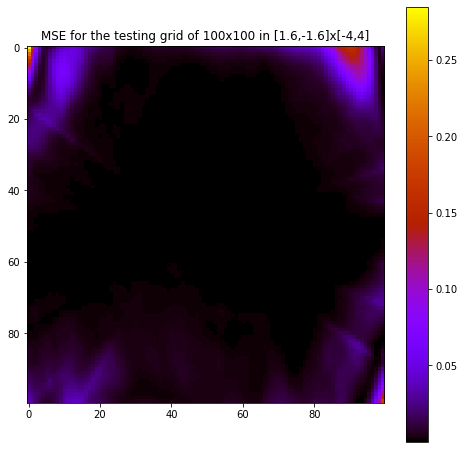

In [32]:
plt.figure(figsize=(8,8))
plt.imshow(ep.reshape(n[0],n[1]), cmap='gnuplot')
plt.title('MSE for the testing grid of {}x{} in [1.6,-1.6]x[-4,4]'.format(n[0], n[1]))
plt.colorbar()
